# Carregar as bibliotecas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from datetime import datetime
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics

# Base MNIST

<p>O banco de dados MNIST (<i>Modified National Institute of Standards and Technology database</i>) é um grande banco de dados de dígitos manuscritos que é comumente usado para treinar vários sistemas de processamento de imagem.</p>

<p>As imagens em preto e branco do MNIST foram normalizadas para caber em uma caixa delimitadora de $28 \times 28$ pixels e suavizadas, o que introduziu níveis de tons de cinza.

O banco de dados MNIST contém 60.000 imagens de treinamento e 10.000 imagens de teste.</p>


<img src="https://drive.google.com/uc?id=16-aNB80uPOX1ZTsbx6MPjx8dyHs4zhJa" alt="MNIST"  width="700"/> </td>



## Carregar base MNIST do módulo *datasets* do Pytorch para classificar usando Rede Neural

In [5]:
# Carrega o conjunto de treino
train_dataset = torchvision.datasets.MNIST(
    root='.', # salva no root
    train=True, # baixa o conjunto de treino
    transform=transforms.ToTensor(), # transforma as imagens em tensores
    download=True # realiza o download das imagens
)

100%|██████████| 9912422/9912422 [00:00<00:00, 81321207.39it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 87273554.63it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20243568.84it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5122486.90it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()


In [7]:
# Carrega o conjunto de teste
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform = transforms.ToTensor(),
    download=True
)

In [8]:
print(test_dataset)

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ToTensor()


## Datalaloader usada para criar batches de imagens

In [9]:
# Data loader
# Cria automáticamente batches de imagens
batch_size = 128 # 128 imagens por batch

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, # utiliza o conjunto de treino
    batch_size = batch_size, # define o número de imagens por batch
    shuffle = True # embaralha as imagens
    )

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, # utiliza o conjunto de treino
    batch_size = batch_size,  # define o número de imagens por batch
    shuffle = False # Não embaralha as imagens. Para o conjunto de teste não é necessário
    )

batch de dados: torch.Size([128, 1, 28, 28])
batch de etiquetas: torch.Size([128])


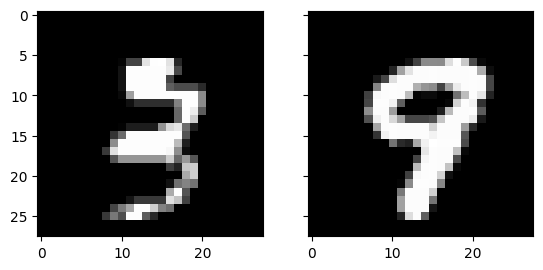

In [10]:
# verificação do funcionamento do dataloader
for x, y in train_loader:
    print(f'batch de dados: {x.shape}')
    print(f'batch de etiquetas: {y.shape}')
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    ax1.imshow(np.transpose(x[0].numpy(), (1,2,0)), cmap = 'gray')
#    ax2.imshow(np.transpose(x[0].numpy(), (1,2,0)), cmap = 'gray')
    ax1.imshow(x[0].numpy()[-1,:,:], cmap = 'gray')
    ax2.imshow(x[1].numpy()[-1,:,:], cmap = 'gray')
    break

# Implementação a rede Lenet

<p>
A arquitetura LeNet foi proposta por um dos avôs do aprendizado profundo, Yann LeCunn. Pelos padrões de hoje, o LeNet é uma rede neural muito rasa, composta pelas seguintes camadas:

(CONV => RELU => POOL) * 2 => FC => RELU => FC => SOFTMAX
</p>

<img src="https://drive.google.com/uc?id=1hn7c0jA0tQDkxfz5LzIiOe3I4KOFydAC" alt="LeNet"  width="700"/> </td>



In [11]:
class Lenet(nn.Module):
    def __init__(self, numChannels, classes):
        # chamar o construtor da classe Base (Pai)
        super(Lenet, self).__init__()

        # definição das camadas convolucionais
        self.conv_layers = nn.Sequential(
            # primeiro grupo convolucional
            nn.Conv2d(in_channels = numChannels, out_channels=20, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # segundo grupo convolucional
            nn.Conv2d(in_channels = 20, out_channels=50, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # definiçao das camadas fully connected
        self.dense_layers = nn.Sequential(
            nn.Linear(in_features=800, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=classes)
        )
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        #out = nn.Flatten(out, start_dim = 1)
        out = self.dense_layers(out)
        return out

In [12]:
# Calcula o tamanho do mapa de características de saída depois de passar
# por uma camada de Convolução
def convolucao(W, F, S, P):
    """
    W: largura do mapa de entrada
    F: tamanho do filtro
    S: stride do filtro
    P: padding
    """
    return int( (W-F+2*P)/S+1 )

In [13]:
# Calcula o tamanho do mapa de características de saída depois de passar
# por uma camada de Pooling
def pooling(W, F, S):
    """
    W: largura do mapa de entrada
    F: tamanho do filtro
    S: stride do filtro
    """
    return int( (W-F)/S+1 )

In [14]:
tam_conv1 = convolucao(28, 5, 1, 0)
print(f'Tamanho do mapa de caracteristicas depois de pasar pela primeira camada de convolução: {tam_conv1}')
tam_pool1 = pooling(tam_conv1, 2, 2)
print(f'Tamanho do mapa de caracteristicas depois de pasar pela primeira camada de pooling: {tam_pool1}')
tam_conv2 = convolucao(tam_pool1, 5, 1, 0)
print(f'Tamanho do mapa de caracteristicas depois de pasar pela segunda camada de convolução: {tam_conv2}')
tam_pool2 = pooling(tam_conv2, 2, 2)
print(f'Tamanho do mapa de caracteristicas depois de pasar pela segunda camada de pooling: {tam_pool2}')
tam_filtros = 50 # número de filtros da segunda camada convolucional
print(f'Número de neuronios de entrada da primeira camada fully connected: {tam_pool2*tam_pool2*tam_filtros}')

Tamanho do mapa de caracteristicas depois de pasar pela primeira camada de convolução: 24
Tamanho do mapa de caracteristicas depois de pasar pela primeira camada de pooling: 12
Tamanho do mapa de caracteristicas depois de pasar pela segunda camada de convolução: 8
Tamanho do mapa de caracteristicas depois de pasar pela segunda camada de pooling: 4
Número de neuronios de entrada da primeira camada fully connected: 800


# Definição da função de treino

In [15]:
def fit(model, criterion, optimizer, train_loader, val_loader, epochs):
    """
    model: a rede neural
    criterion: função de custo (Loss function)
    optimizer: função de otimização que minimiza a função de custo
    train_loader: conjunto de treino dividido em batches
    val_loader: conjunto de validação dividido em batches
    """
    train_losses = np.zeros( epochs )
    val_losses = np.zeros( epochs )

    for it in range(epochs):
        model.train() # setar a rede em modo treino
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )

        train_loss = np.mean(train_loss)

        val_loss = []
        for inputs, targets in val_loader:
            model.eval() # setar a rede em modo validação (pesos não são atualizados)
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item())
        val_loss = np.mean(val_loss)

        # salvar losses
        train_losses[it] = train_loss
        val_losses[it] = val_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} Validation Loss: {val_loss} Duracao: {dt}')

    return train_losses, val_losses

# Modulo para avaliar o conjunto de teste

In [16]:
def predict_module(model, test_loader):

    model.eval() # a rede é colocada em modo avaliação, nenhum peso é atualizado
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in test_loader:
        # mover os dados para o GPU
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions.cpu())
        true_labels = np.append(true_labels, targets.cpu())

    return predicted, true_labels

## Calculo da matriz de confusão

In [17]:
def matriz_confusao(true_labels, predicted, display_labels=[0,1,2]):
    """
    true_labels: verdadeiras etiquetas (classes) do conjunto de dados avaliado
    predicted: etiquetas (classes) geradas pelo classificador
    display_labels: valores das etiquetas
    """
    matriz = metrics.confusion_matrix(true_labels, predicted)
    tot = np.sum(matriz, axis=1, keepdims=True)
    np.set_printoptions(precision=2)
    m_porc = matriz/tot
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=display_labels)
    disp.plot(values_format='.2f')
    plt.show()

## Função para graficar as funções de perda do treino e da validação

In [18]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label = 'train loss')
    plt.plot(test_losses, label = 'test loss')
    plt.legend()
    plt.show()

# Treino

In [19]:
# Instanciar a rede
# A base MNIST consta de imagens em escala de cinza, ou seja, tem um único canal de cor
model = Lenet(numChannels=1, classes=10)

### A rede neural é enviada ao dispositivo disponível (CPU ou GPU)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cpu


## Definição das função de custo (Loss function) e do otimizador

In [21]:
# Loss para varias classes
criterion = nn.CrossEntropyLoss()
# Optimizer
#optimizer = torch.optim.Adagrad( model.parameters() )
optimizer = torch.optim.SGD(model.parameters(),
                                    lr=0.001,
                                    momentum=0.9,
                                    weight_decay=1e-3)

Epoch 1/10 Train Loss: 1.8155 Validation Loss: 0.5980859379979628 Duracao: 0:00:59.014659
Epoch 2/10 Train Loss: 0.4333 Validation Loss: 0.3213499619896653 Duracao: 0:00:58.075294
Epoch 3/10 Train Loss: 0.2914 Validation Loss: 0.2306682306895905 Duracao: 0:01:02.569398
Epoch 4/10 Train Loss: 0.2231 Validation Loss: 0.1807245894606355 Duracao: 0:01:00.219353
Epoch 5/10 Train Loss: 0.1804 Validation Loss: 0.14508554753788475 Duracao: 0:01:00.847934
Epoch 6/10 Train Loss: 0.1510 Validation Loss: 0.11966010990045682 Duracao: 0:00:57.495327
Epoch 7/10 Train Loss: 0.1307 Validation Loss: 0.11204011645168066 Duracao: 0:00:58.512603
Epoch 8/10 Train Loss: 0.1155 Validation Loss: 0.09436141096255919 Duracao: 0:00:56.739392
Epoch 9/10 Train Loss: 0.1042 Validation Loss: 0.09858597363522158 Duracao: 0:00:57.942988
Epoch 10/10 Train Loss: 0.0954 Validation Loss: 0.07901272489807179 Duracao: 0:00:59.609658


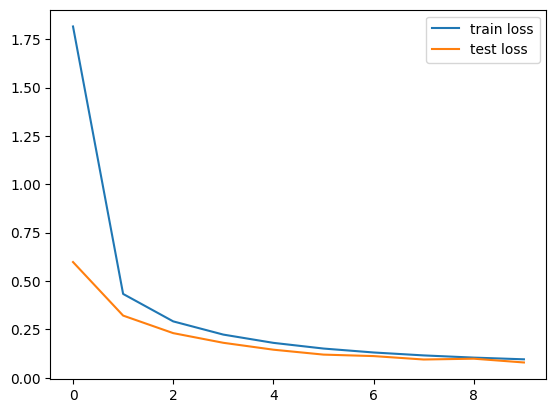

In [22]:
# treino da rede
train_losses, val_losses = fit(model, criterion, optimizer, train_loader, test_loader, epochs = 10)
# graficar as funções de perda
plot_losses(train_losses, val_losses)

# Teste

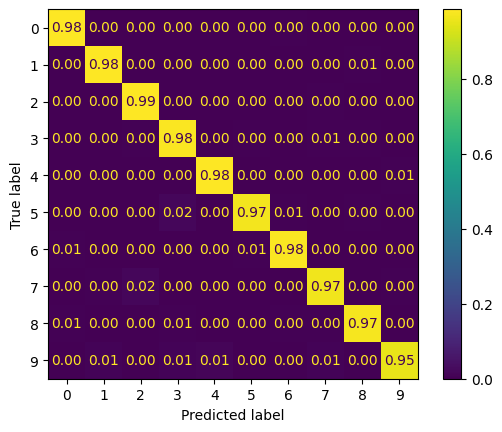

In [23]:
# Avaliando a rede treinada com o conjunto de teste
predicted, true_labels = predict_module(model, test_loader)
matriz_confusao(true_labels, predicted, [0,1,2,3,4,5,6,7,8,9])

## Questão 1
<p>
Crie uma nova rede neural convolucional. Ela deve estar composta pelas seguintes camadas:
<ul>
  <li>1 Camada convolucional com 32 filtros, um kernel de $ 3 \times 3$, stride de 2. Não será realizada nenhuma operação de padding</li>
  <li>1 camada de função de ativaçao ReLU</li>
  <li>1 Camada convolucional com 64 filtros, um kernel de $ 3 \times 3$, stride de 2. Não será realizada nenhuma operação de padding</li>
  <li>1 camada de função de ativaçao ReLU</li>
  <li>1 Camada convolucional com 128 filtros, um kernel de $ 3 \times 3$, stride de 2. Não será realizada nenhuma operação de padding</li>
  <li>1 camada de função de ativaçao ReLU</li>
  <li>1 camada fully-connected de 256 neuronios </li>
  <li>1 camada de função de ativação ReLU</li>
  <li>1 camada fully-connected do tamanho do número de classes</li>
</ul>
(CONV => RELU ) * 3 => FC => RELU => FC => SOFTMAX

A rede deve ser treinada com a base Fashion-MNIST
</p>

In [24]:
class MinhaCNN(nn.Module):
    def __init__(self, numChannels, classes):
        # chamar o construtor da classe Base (Pai)
        super(MinhaCNN, self).__init__()

        # definição das camadas convolucionais
        self.conv32 = nn.Conv2d(in_channels=numChannels, out_channels=32, kernel_size=3, stride=2)
        self.relu32 = nn.ReLU()
        self.conv64 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.relu64 = nn.ReLU()
        self.conv128 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.relu128 = nn.ReLU()

        # definiçao das camadas fully connected
        self.fc256 =  nn.Linear(128 * 2 * 2, 256)
        self.relu = nn.ReLU()
        self.fcclass = nn.Linear(256, classes)

    def forward(self, x):
        x = self.conv32(x)
        x = self.relu32(x)
        x = self.conv64(x)
        x = self.relu64(x)
        x = self.conv128(x)
        x = self.relu128(x)

        x = x.view(x.size(0), -1)

        x = self.fc256(x)
        x = self.relu(x)
        out = self.fcclass(x)

        return out

## Calcular a dimensão de entrada da primeira camada fully connected

In [25]:
tam_conv1 = 13
print(f'Tamanho do mapa de caracteristicas depois de pasar pela primeira camada de convolução: {tam_conv1}')
tam_conv2 = tam_conv1 - 7
print(f'Tamanho do mapa de caracteristicas depois de pasar pela segunda camada de convolução: {tam_conv2}')
tam_conv3 = tam_conv2 - 4
print(f'Tamanho do mapa de caracteristicas depois de pasar pela segunda camada de convolução: {tam_conv3}')

tam_filtros = 128 # número de filtros da segunda camada convolucional
print(f'Número de neuronios de entrada da primeira camada fully connected: {tam_conv3*tam_conv3*tam_filtros}')

Tamanho do mapa de caracteristicas depois de pasar pela primeira camada de convolução: 13
Tamanho do mapa de caracteristicas depois de pasar pela segunda camada de convolução: 6
Tamanho do mapa de caracteristicas depois de pasar pela segunda camada de convolução: 2
Número de neuronios de entrada da primeira camada fully connected: 512


#Fashion MNIST

<p>Fashion-MNIST é um conjunto de dados de imagens de <i>Zalando's article images</i>, consistindo em um conjunto de treinamento de 60.000 exemplos e um conjunto de teste de 10.000 exemplos. Cada exemplo é uma imagem em tons de cinza 28x28, associada a um rótulo de 10 classes.</p>

<p>A base consiste de 10 classes:
<ol>
  <li>camiseta/top</li>
  <li>Calça</li>
  <li>Pulôver</li>
  <li>vestido</li>
  <li>Casaco</li>
  <li>Sandália</li>
  <li>camisa</li>
  <li>tênis</li>
  <li>bolsas</li>
  <li>Tornozelo</li>
</ol>

<img src="https://drive.google.com/uc?id=1BIHLjrMID4Em3DaL2PzKLC1Q3oY5FUDw" alt="MNIST"  width="700"/> </td>



## Carregando base Fashion-MNIST

In [26]:
train_dataset_fashion = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

100%|██████████| 26421880/26421880 [00:01<00:00, 17522831.73it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 307160.47it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5580881.20it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16545806.12it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [27]:
test_dataset_fashion = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

## Datalaloader usada para criar batches de imagens

In [28]:
# Data loader
# Cria automáticamente batches de imagens
batch_size = 128 # 128 imagens por batch

train_loader_fashion = torch.utils.data.DataLoader(dataset = train_dataset_fashion, # utiliza o conjunto de treino
    batch_size = batch_size, # define o número de imagens por batch
    shuffle = True # embaralha as imagens
    )

test_loader_fashion = torch.utils.data.DataLoader(dataset = test_dataset_fashion, # utiliza o conjunto de treino
    batch_size = batch_size,  # define o número de imagens por batch
    shuffle = False # Não embaralha as imagens. Para o conjunto de teste não é necessário
)

### Mostrando alguns exemplos da base

batch de dados: torch.Size([128, 1, 28, 28])
batch de etiquetas: torch.Size([128])


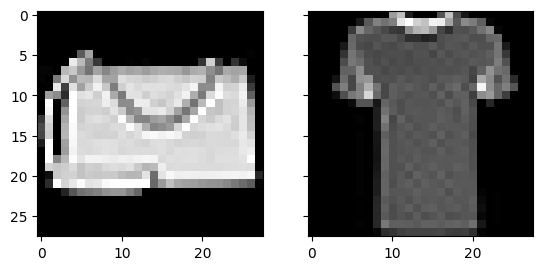

In [29]:
# verificação do funcionamento do dataloader
for x, y in train_loader_fashion:
    print(f'batch de dados: {x.shape}')
    print(f'batch de etiquetas: {y.shape}')
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    ax1.imshow(np.transpose(x[0].numpy(), (1,2,0)), cmap = 'gray')
#    ax2.imshow(np.transpose(x[0].numpy(), (1,2,0)), cmap = 'gray')
    ax1.imshow(x[0].numpy()[-1,:,:], cmap = 'gray')
    ax2.imshow(x[1].numpy()[-1,:,:], cmap = 'gray')
    break

In [31]:
# Instanciar a rede
# A base MNIST consta de imagens em escala de cinza, ou seja, tem um único canal de cor
model_fashion = MinhaCNN(numChannels=1, classes=10)

In [32]:
model_fashion.to(device)
print(device)

cpu


In [33]:
# Loss para varias classes
criterion_fashion = nn.CrossEntropyLoss()
# Optimizer
#optimizer = torch.optim.Adagrad( model.parameters() )
optimizer_fashion = torch.optim.SGD(model_fashion.parameters(),
                                    lr=0.001,
                                    momentum=0.9,
                                    weight_decay=1e-3)

Epoch 1/10 Train Loss: 2.2917 Validation Loss: 2.265176564832277 Duracao: 0:00:29.535230
Epoch 2/10 Train Loss: 1.7298 Validation Loss: 0.9625276304498503 Duracao: 0:00:29.805475
Epoch 3/10 Train Loss: 0.8306 Validation Loss: 0.7663757819918138 Duracao: 0:00:30.995458
Epoch 4/10 Train Loss: 0.7305 Validation Loss: 0.7221661583532261 Duracao: 0:00:31.720515
Epoch 5/10 Train Loss: 0.6915 Validation Loss: 0.7101651769650134 Duracao: 0:00:30.492202
Epoch 6/10 Train Loss: 0.6608 Validation Loss: 0.686481920978691 Duracao: 0:00:29.837589
Epoch 7/10 Train Loss: 0.6348 Validation Loss: 0.6369125239456757 Duracao: 0:00:29.676571
Epoch 8/10 Train Loss: 0.6113 Validation Loss: 0.6270898542826688 Duracao: 0:00:30.351768
Epoch 9/10 Train Loss: 0.5921 Validation Loss: 0.6033353911170477 Duracao: 0:00:29.695019
Epoch 10/10 Train Loss: 0.5728 Validation Loss: 0.5883072863651228 Duracao: 0:00:31.246036


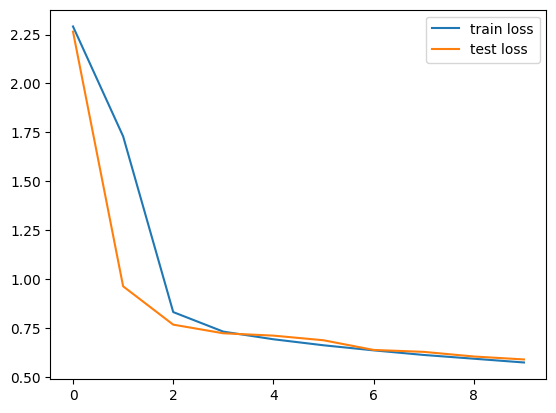

In [34]:
# treino da rede
train_losses_fashion, val_losses_fashion = fit(model_fashion, criterion_fashion, optimizer_fashion, train_loader_fashion, test_loader_fashion, epochs = 10)
# graficar as funções de perda
plot_losses(train_losses_fashion, val_losses_fashion)

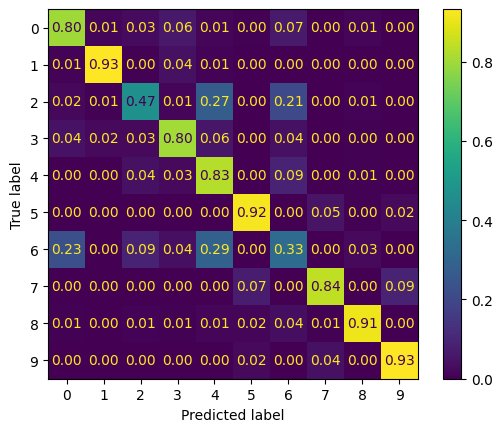

In [35]:
# Avaliando a rede treinada com o conjunto de teste
predicted, true_labels = predict_module(model_fashion, test_loader_fashion)
matriz_confusao(true_labels, predicted, [0,1,2,3,4,5,6,7,8,9])

In [ ]:
# treino da rede
train_losses_fashion, val_losses_fashion = fit(model_fashion, criterion_fashion, optimizer_fashion, train_loader_fashion, test_loader_fashion, epochs = 50)
# graficar as funções de perda
plot_losses(train_losses_fashion, val_losses_fashion)

Epoch 1/50 Train Loss: 0.5423 Validation Loss: 0.5489483915175064 Duracao: 0:00:31.758358
Epoch 2/50 Train Loss: 0.5269 Validation Loss: 0.540774246937112 Duracao: 0:00:30.109570
Epoch 3/50 Train Loss: 0.5133 Validation Loss: 0.5297472314744056 Duracao: 0:00:30.462083
Epoch 4/50 Train Loss: 0.5040 Validation Loss: 0.5319419167464292 Duracao: 0:00:30.548300
Epoch 5/50 Train Loss: 0.4925 Validation Loss: 0.540193961956833 Duracao: 0:00:29.911171
Epoch 6/50 Train Loss: 0.4867 Validation Loss: 0.5029493875895874 Duracao: 0:00:30.602625
Epoch 7/50 Train Loss: 0.4757 Validation Loss: 0.49758045130138157 Duracao: 0:00:30.945065
Epoch 8/50 Train Loss: 0.4693 Validation Loss: 0.48898674509947815 Duracao: 0:00:30.517618
Epoch 9/50 Train Loss: 0.4607 Validation Loss: 0.4927148458701146 Duracao: 0:00:29.855477
Epoch 10/50 Train Loss: 0.4552 Validation Loss: 0.48367803383477126 Duracao: 0:00:29.434190
Epoch 11/50 Train Loss: 0.4477 Validation Loss: 0.47401689219323895 Duracao: 0:00:30.815579
Epoch 

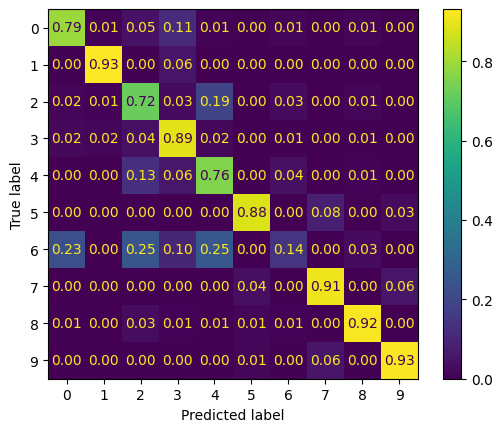

In [37]:
# Avaliando a rede treinada com o conjunto de teste
predicted, true_labels = predict_module(model_fashion, test_loader_fashion)
matriz_confusao(true_labels, predicted, [0,1,2,3,4,5,6,7,8,9])

## Dividir em três conjuntos: treino, validação e teste

In [38]:
train_dataset_split, val_dataset_split = torch.utils.data.random_split(train_dataset_fashion, [0.8, 0.2])

# Questão 2
<p>
Instancie um novo modelo, função de perda e de otimização e treine com o conjunto de treino e validação. Logo, avalie a acurácia do modelo com o conjunto de teste.</p>

Epoch 1/10 Train Loss: 0.6509 Validation Loss: 0.4854685950882827 Duracao: 0:00:33.117188
Epoch 2/10 Train Loss: 0.4232 Validation Loss: 0.395626712260367 Duracao: 0:00:32.146951
Epoch 3/10 Train Loss: 0.3606 Validation Loss: 0.3758651687751842 Duracao: 0:00:31.127922
Epoch 4/10 Train Loss: 0.3227 Validation Loss: 0.35142010506949845 Duracao: 0:00:32.009866
Epoch 5/10 Train Loss: 0.2955 Validation Loss: 0.3281418461399742 Duracao: 0:00:31.889789
Epoch 6/10 Train Loss: 0.2706 Validation Loss: 0.30806715107416804 Duracao: 0:00:31.979017
Epoch 7/10 Train Loss: 0.2522 Validation Loss: 0.3169710178258298 Duracao: 0:00:31.999478
Epoch 8/10 Train Loss: 0.2335 Validation Loss: 0.2940030563858491 Duracao: 0:00:32.126875
Epoch 9/10 Train Loss: 0.2177 Validation Loss: 0.30180137010314795 Duracao: 0:00:30.973608
Epoch 10/10 Train Loss: 0.2010 Validation Loss: 0.30349894584734227 Duracao: 0:00:31.976358


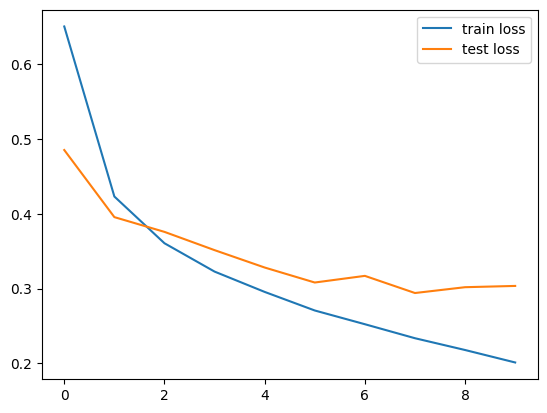

acurácia do novo modelo com o conjunto de teste: 0.896300


In [39]:
# instanciando novo modelo
new_model_fashion = MinhaCNN(numChannels=1, classes=10)
new_model_fashion.to(device)

# função de perda
new_criterion_fashion = nn.CrossEntropyLoss()

# otimizador
new_optimizer_fashion = torch.optim.Adam(new_model_fashion.parameters(), lr=0.001)

# treinando com cnj de treino e validação
new_train_losses_fashion, new_val_losses_fashion = fit(new_model_fashion, new_criterion_fashion, new_optimizer_fashion, train_loader_fashion, test_loader_fashion, epochs=10)

# plotando grafico das funções de perda
plot_losses(new_train_losses_fashion, new_val_losses_fashion)

# acurácia com o cnj de teste
new_predicted, new_true_labels = predict_module(new_model_fashion, test_loader_fashion)

# calculo da acurácia
accuracy = metrics.accuracy_score(new_true_labels, new_predicted)
print(f'acurácia do novo modelo com o conjunto de teste: {accuracy:f}')